#Reference
https://www.tensorflow.org/text/tutorials/text_classification_rnn#stack_two_or_more_lstm_layers

In [1]:
!pip install datasets
!pip install tensorflow_text
!pip install sentencepiece
!pip install Sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 15.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 48.7 MB/s eta 0:00

In [2]:
import tensorflow as tf

from tensorflow.keras import Sequential, layers, Input, Model
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
import keras
import numpy as np
import pandas as pd
import json
import csv
from datasets import list_datasets, load_dataset

#Kaggle

In [3]:
!pip install -q kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"dafagaming123","key":"26d41639614b8fc75387801be2754587"}
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d oswinrh/indonesian-stoplist
!unzip -n indonesian-stoplist.zip

  0% 0.00/2.27k [00:00<?, ?B/s]
100% 2.27k/2.27k [00:00<00:00, 3.88MB/s]
Archive:  indonesian-stoplist.zip
  inflating: stopwordbahasa.csv      


In [4]:
data = load_dataset("indonlp/indonlu", 'smsa')

Generating train split:   0%|          | 0/11000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1260 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/500 [00:00<?, ? examples/s]

Dataset indonlu downloaded and prepared to /root/.cache/huggingface/datasets/indonlp___indonlu/smsa/1.0.0/4f6bd3985d38bfa901609cc151c052caaa4612322688a67e5aec267a78e930a0. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
data

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 11000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1260
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 500
    })
})

In [6]:
df_train = pd.DataFrame(data['train'])
df_val = pd.DataFrame(data['validation'])
df_test = pd.DataFrame(data['test'])

stoplist = pd.read_csv("stopwordbahasa.csv")
stoplist = stoplist.to_numpy()

In [ ]:
df_train.groupby('label').nunique()

,text
label,
0,6383
1,1138
2,3412


Tokenizer

In [ ]:
large_dataset = pd.concat([df_train, df_val, df_test])

In [ ]:
tokenizer = Tokenizer(num_words=1000, oov_token='<OOV>')
tokenizer.fit_on_texts(large_dataset.text)

Stemmer

In [ ]:
# create stemmer 
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [ ]:
def preprocess(text):
  sentence = text.lower()
  words = text_to_word_sequence(sentence)
  words =  [word for word in words if len(word) > 2 and word.isalnum()]
  words = [word for word in words if word not in stoplist]

  words     = ' '.join(words)
  sentence  =  stemmer.stem(sentence)

  sentence  = tokenizer.texts_to_sequences([sentence])
  words_indices = pad_sequences(sentence, maxlen=50, padding='post', truncating='post')[0]

  return words_indices

In [ ]:
preprocess("Maksudnya gimana sih?")

array([ 1,  1, 85,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)

In [ ]:
def text_preprocess(dataframe):
  df = dataframe.copy()

  # Lowering
  df['text_clean'] = df['text'].apply(lambda text_string: preprocess(text_string))

  # # Split word
  # df['text_clean'] = df['text_clean'].apply(lambda sentence: text_to_word_sequence(sentence))

  # # Filtering and remove stop word
  # df['text_clean'] = df['text_clean'].apply(lambda words: [word for word in words if len(word) > 2 and word.isalnum()])
  # df['text_clean'] = df['text_clean'].apply(lambda words: [word for word in words if word not in stoplist])

  # # Stemming
  # df['text_clean'] = df['text_clean'].apply(lambda words: ' '.join(words))
  # df['text_clean'] = df['text_clean'].apply(lambda sentence: stemmer.stem(sentence))

  # # Tokenize and padding
  # df['text_clean'] = df['text_clean'].apply(lambda sentence: tokenizer.texts_to_sequences([sentence]))
  # df['text_clean'] = df['text_clean'].apply(lambda words_indices: pad_sequences(words_indices, maxlen=50, padding='post', truncating='post')[0])
  
  return df

Text preprocess will take a time due to stemming
15-20 minutes

In [ ]:
train = text_preprocess(df_train)
val = text_preprocess(df_val)
test = text_preprocess(df_test)

In [ ]:
words = train.loc[2].text
print(words, type(words), len(words))

lokasi strategis di jalan sumatera bandung . tempat nya nyaman terutama sofa di lantai 2 . paella nya enak , sangat pas dimakan dengan minum bir dingin . appetiser nya juga enak-enak . <class 'str'> 184


#Imbalanced Dataset

In [ ]:
# def undersampling(df):
#   positive  = df[(df['label']==0)]
#   neutral   = df[(df['label']==1)]
#   negative  = df[(df['label']==2)]
#   print("Before\nPositive: {}, Neutral: {}, Negative: {}".format(len(positive),len(neutral), len(negative)))
#   positive = positive.sample(n=len(negative), random_state=101)
#   df = pd.concat([positive,neutral,negative],axis=0)
#   positive  = df[(df['label']==0)]
#   neutral   = df[(df['label']==1)]
#   negative  = df[(df['label']==2)]
#   print("After\nPositive: {}, Neutral: {}, Negative: {}\n".format(len(positive),len(neutral), len(negative)))
#   return df

In [ ]:
# train = undersampling(train)
# val = undersampling(val)
# test =undersampling(test)

#Convert into TFDataset

In [ ]:
batch_size = 32 

In [ ]:
# Ini fix unsupported value list
X_train = train['text_clean'].to_list()
X_val = val['text_clean'].to_list()
X_test = test['text_clean'].to_list()

In [ ]:
  # ini lengthny harus sama semua
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_train, train.label))
    .shuffle(100)
    .batch(batch_size)
)

val_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_val, val.label))
    .shuffle(100)
    .batch(batch_size)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_test, test.label))
    .shuffle(100)
    .batch(batch_size)
)

## Model Building

In [ ]:
max_sen_length = 512

model = Sequential([
    Input(shape=(50,)),
    layers.Embedding(1000, 100, input_length=50),
    layers.Bidirectional(layers.LSTM(16)),
    # layers.Bidirectional(layers.LSTM(16)),
    layers.Dense(8),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax'),

])

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           100000    
                                                                 
 bidirectional (Bidirectiona  (None, 32)               14976     
 l)                                                              
                                                                 
 dense (Dense)               (None, 8)                 264       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 3)                 27        
                                                                 
Total params: 115,267
Trainable params: 115,267
Non-trainable params: 0
__________________________________________________

In [ ]:
history = model.fit(train_dataset, epochs=15,validation_data=(val_dataset))

Epoch 1/15
344/344 [==============================] - 31s 61ms/step - loss: 0.6525 - accuracy: 0.7200 - val_loss: 0.4435 - val_accuracy: 0.8492
Epoch 2/15
344/344 [==============================] - 5s 14ms/step - loss: 0.4486 - accuracy: 0.8326 - val_loss: 0.3916 - val_accuracy: 0.8563
Epoch 3/15
344/344 [==============================] - 5s 16ms/step - loss: 0.3948 - accuracy: 0.8541 - val_loss: 0.3844 - val_accuracy: 0.8651
Epoch 4/15
344/344 [==============================] - 4s 11ms/step - loss: 0.3505 - accuracy: 0.8730 - val_loss: 0.3984 - val_accuracy: 0.8484
Epoch 5/15
344/344 [==============================] - 4s 11ms/step - loss: 0.3413 - accuracy: 0.8774 - val_loss: 0.3903 - val_accuracy: 0.8437
Epoch 6/15
344/344 [==============================] - 3s 8ms/step - loss: 0.3124 - accuracy: 0.8847 - val_loss: 0.4191 - val_accuracy: 0.8532
Epoch 7/15
344/344 [==============================] - 3s 8ms/step - loss: 0.2940 - accuracy: 0.8906 - val_loss: 0.4145 - val_accuracy: 0.8532


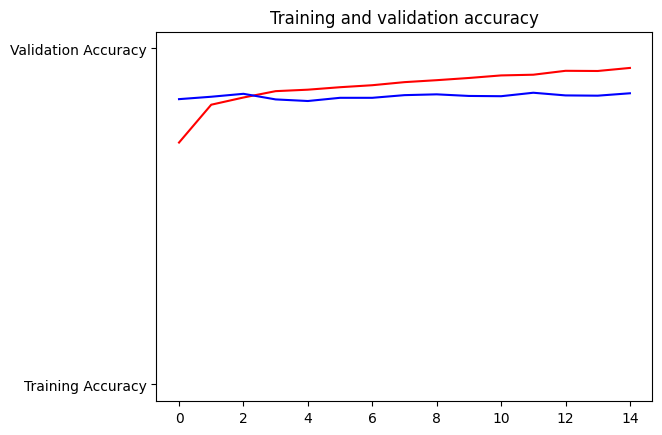

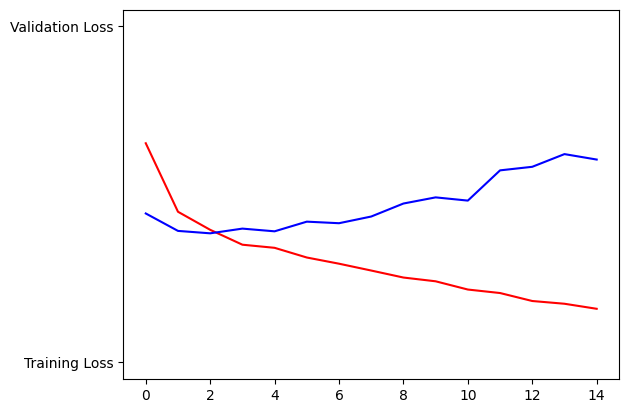

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset, verbose=2)
print('Model accuracy: ',test_acc)

16/16 - 0s - loss: 0.9313 - accuracy: 0.7880 - 84ms/epoch - 5ms/step
Model accuracy:  0.7879999876022339


In [ ]:
predictions = model.predict(test_dataset)

16/16 [==============================] - 1s 4ms/step


In [ ]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(test['label'], np.around(predictions, decimals=0).argmax(axis=1))

<ipython-input-42-98621eeb8031>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


Text(0.5, 23.52222222222222, 'Prediction')

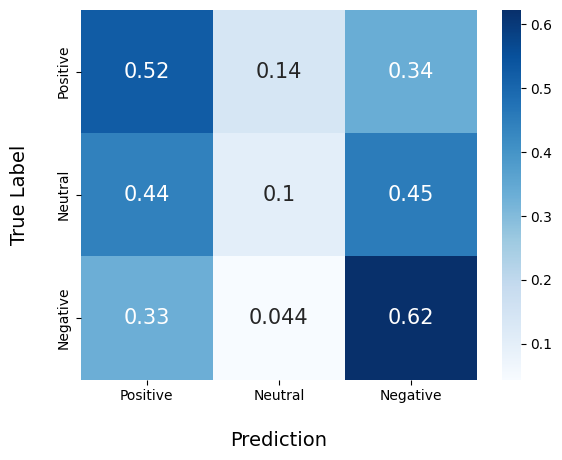

In [ ]:
import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['Positive','Neutral','Negative'],columns = ['Positive','Neutral','Negative'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
ax = sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15}, cmap='Blues')
ax.set_ylabel("True Label", fontsize=14, labelpad=20)
ax.set_xlabel("Prediction", fontsize=14, labelpad=20)


# Conclusion
The model already good in negative prediction, its very bad at neutral prediction, also positive in the second place

In [ ]:
sentiment = ['Positive','Neutral','Negative']

In [ ]:
train_dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 50), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
sequence = 'kerjanya males malesan'
test_seq = preprocess(sequence)
test_seq = tf.expand_dims(test_seq, -1)
# print(test_seq.shape)
# model.predict(test_seq)
sentiment[np.around(model.predict(test_seq), decimals=0).argmax(axis=1)[0]]

2/2 [==============================] - 0s 9ms/step


'Positive'

#NNLM Transfer Learning

In [ ]:
# Ini fix unsupported value list
X_train = df_train['text'].to_list()
X_val = df_val['text'].to_list()
X_test = df_test['text'].to_list()

In [ ]:
  # ini lengthny harus sama semua
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_train, train.label))
    .shuffle(100)
    .batch(batch_size)
)

val_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_val, val.label))
    .shuffle(100)
    .batch(batch_size)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_test, test.label))
    .shuffle(100)
    .batch(batch_size)
)

In [ ]:
import tensorflow_hub as hub

In [ ]:
nnlm = "https://tfhub.dev/google/nnlm-id-dim128-with-normalization/2"
hub_layer = hub.KerasLayer(nnlm, input_shape=[], dtype=tf.string, trainable=False)

In [ ]:
model = Sequential([
    hub_layer,
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax'),
])
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               112461824 
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 3)                 195       
                                                                 
Total params: 112,486,787
Trainable params: 24,963
Non

In [ ]:
history = model.fit(train_dataset, epochs=15,validation_data=(val_dataset))

Epoch 1/15
344/344 [==============================] - 4s 6ms/step - loss: 0.5565 - accuracy: 0.7733 - val_loss: 0.4167 - val_accuracy: 0.8357
Epoch 2/15
344/344 [==============================] - 1s 4ms/step - loss: 0.4299 - accuracy: 0.8423 - val_loss: 0.3895 - val_accuracy: 0.8500
Epoch 3/15
344/344 [==============================] - 1s 4ms/step - loss: 0.4042 - accuracy: 0.8516 - val_loss: 0.3864 - val_accuracy: 0.8437
Epoch 4/15
344/344 [==============================] - 1s 4ms/step - loss: 0.3773 - accuracy: 0.8586 - val_loss: 0.3671 - val_accuracy: 0.8587
Epoch 5/15
344/344 [==============================] - 1s 4ms/step - loss: 0.3640 - accuracy: 0.8606 - val_loss: 0.3724 - val_accuracy: 0.8476
Epoch 6/15
344/344 [==============================] - 1s 4ms/step - loss: 0.3553 - accuracy: 0.8672 - val_loss: 0.3605 - val_accuracy: 0.8643
Epoch 7/15
344/344 [==============================] - 1s 4ms/step - loss: 0.3442 - accuracy: 0.8739 - val_loss: 0.3596 - val_accuracy: 0.8571
Epoch 

In [ ]:
sequence = ['kerjanya lama gak becus']
sentiment[np.around(model.predict(sequence), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 430ms/step


'Negative'

##Testset

In [ ]:
predictions = model.predict(test_dataset)

16/16 [==============================] - 0s 5ms/step


<ipython-input-75-77d61eb8ad7f>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


Text(0.5, 23.52222222222222, 'Prediction')

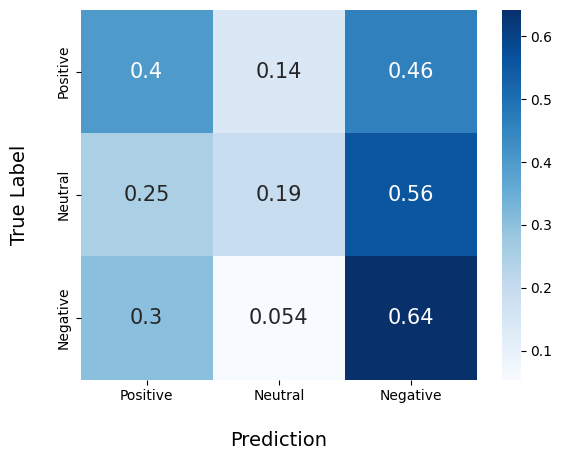

In [ ]:
matrix = confusion_matrix(test['label'], np.around(predictions, decimals=0).argmax(axis=1))
conf_matrix = pd.DataFrame(matrix, index = ['Positive','Neutral','Negative'],columns = ['Positive','Neutral','Negative'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
ax = sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15}, cmap='Blues')
ax.set_ylabel("True Label", fontsize=14, labelpad=20)
ax.set_xlabel("Prediction", fontsize=14, labelpad=20)
